In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from scipy.fftpack import fft, ifft, fftfreq
import csv


In [14]:
def get_symbols_from_directory(directory):
    all_files = [f for f in os.listdir(directory) if f.endswith(".csv")]
    symbols = [file.replace("_15m_data.csv", "") for file in all_files]
    return symbols

In [ ]:
def load_data(directory="data"):
    data = {}
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            symbol = file.replace("_15m_data.csv", "")
            path = os.path.join(directory, file)
            df = pd.read_csv(path, parse_dates=['timestamp']).set_index('timestamp')
            
            required_columns = {"open", "high", "low", "close", "volume", "turnover"}
            if required_columns.issubset(df.columns):
                data[symbol] = df
    return data

In [16]:
def compute_fft(signal, sample_rate=None):
    N = len(signal)
    sample_rate = sample_rate or N

    # הסרת התוחלת מהסיגנל
    signal = signal - np.mean(signal)

    # ריפוד לחזקה הקרובה של 2
    N_padded = 2 ** (N - 1).bit_length()
    padded_signal = np.pad(signal, (0, N_padded - N), mode='constant')

    fft_values = fft(padded_signal)
    freqs = fftfreq(N_padded, d=1/sample_rate)
    
    return freqs, fft_values


In [17]:
def find_cutoff_frequency(freqs, fft_values, energy_ratio):
    power_spectrum = np.abs(fft_values) ** 2
    sorted_indices = np.argsort(freqs)
    sorted_power = power_spectrum[sorted_indices]
    
    total_energy = np.sum(sorted_power)
    cumulative_energy = np.cumsum(sorted_power)
    
    cutoff_index = np.searchsorted(cumulative_energy, energy_ratio * total_energy)
    cutoff_freq = freqs[sorted_indices][cutoff_index]
    
    return cutoff_freq

In [18]:
def filter_fft(freqs, fft_values, cutoff_frequency):
    fft_filtered = fft_values.copy()
    fft_filtered[np.abs(freqs) > cutoff_frequency] = 0
    filtered_signal = np.real(ifft(fft_filtered))
    
    return filtered_signal


In [19]:
def plot_signal(signal, title, xlabel='Time', ylabel='Value'):
    plt.figure(figsize=(12, 6))
    plt.plot(signal, color='blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [20]:
def plot_fft(freqs, fft_values, title):
    plt.figure(figsize=(12, 6))
    plt.plot(freqs[:len(freqs)//2], np.abs(fft_values)[:len(fft_values)//2], color='red')
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

500500


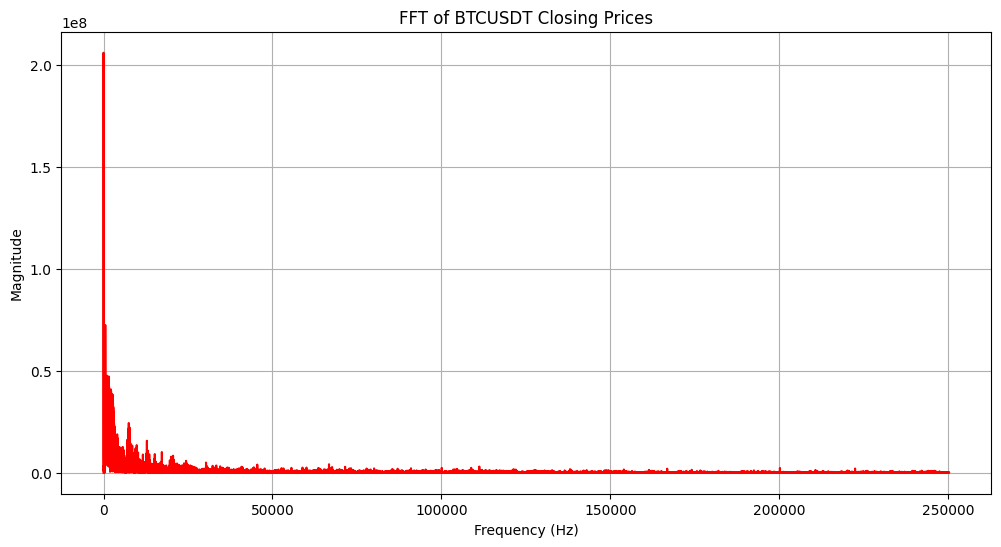

Cutoff Frequency: 2753.14712524414


In [24]:
data = load_data("data")
btc_data = data["BTCUSDT"]["close"].values
print(len(btc_data))
    # שלב 1: FFTדד
freqs, fft_values = compute_fft(btc_data)
plot_fft(freqs, fft_values, "FFT of BTCUSDT Closing Prices")

    # שלב 2: מציאת תדר חיתוך
cutoff_frequency = find_cutoff_frequency(freqs, fft_values, energy_ratio=0.9)
print(f"Cutoff Frequency: {cutoff_frequency}")

    # שלב 3: סינון ושחזור הסיגנל
#filtered_signal = filter_fft(freqs, fft_values, cutoff_frequency)
#plot_signal(filtered_signal, "Filtered Signal of BTCUSDT Closing Prices")

In [25]:
features = ["open", "high", "low","close", "volume", "turnover"]
data_to_save = []
symbols = get_symbols_from_directory("data")

for symbol in symbols:
    row = [symbol]  # שם הסימבול
    symbol_data = data[symbol]  # מביאים את הדאטה לפי השם
    for feature in features:
        freqs, fft_values = compute_fft(symbol_data[feature])
        #print(len(symbol_data[feature]))
        cutoff_frequency = find_cutoff_frequency(freqs, fft_values, energy_ratio=0.9)
        row.append(round(cutoff_frequency)*2)
        #if feature == "volume" or feature == "turnover"
    data_to_save.append(row)

# כתיבה ל־CSV
csv_filename = "symbols_cutoff_frequencies.csv"
with open(csv_filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Symbol"] + features)
    writer.writerows(data_to_save)
